# Deeper Look into Fine Channelization
This notebook takes a closer look into the specifics in fine channelization.

If you have access to a GPU, it is highly recommended to install CuPy, which performs the equivalent NumPy array operations on the GPU (https://docs.cupy.dev/en/stable/install.html). This is not necessary to run raw voltage generation, but will highly accelerate the pipeline. If you do install CuPy to use the GPU, it can be useful to run `export CUDA_VISIBLE_DEVICES=0` before running this notebook to specify a single GPU to use.

In [1]:
# !pip install cupy-cuda110

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt

try:
    import cupy as xp
except ImportError:
    import numpy as xp
import numpy as np

import numpy as np
import scipy.signal
from scipy.signal import firwin, freqz
import matplotlib.pyplot as plt

from astropy import units as u
import blimpy as bl

import sys
sys.path.insert(0, "../../")
import setigen as stg

def get_numpy(v):
    try:
        return xp.asnumpy(v)
    except AttributeError:
        return v
    
def db(x):
    """ Convert linear value to dB value """
    return 10*np.log10(x)

bshuf filter already loaded, skip it.
lz4 filter already loaded, skip it.
zfp filter already loaded, skip it.


In [2]:
# Sometimes it can be necessary to re-run this command for plots to show automatically
%matplotlib inline

We first set some basic parameters behind the pipeline. `sample_rate` is in samples per second (Hz); `num_taps` and `num_branches` are specific to the polyphase filterbank described below. 

In [3]:
sample_rate = 3e9
num_taps = 8
num_branches = 1024

chan_bw = sample_rate / num_branches

digitizer = stg.voltage.RealQuantizer(target_fwhm=32,
                                      num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

num_bits = 8
target_fwhm = 32*2**num_bits/2**8
requantizer = stg.voltage.ComplexQuantizer(target_fwhm=target_fwhm,
                                           num_bits=num_bits)

We can estimate the frequency response of the PFB filter using an FFT. Plotting half of a coarse channel (and assuming this response is symmetric about every coarse channel):

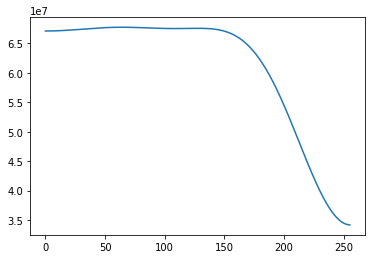

In [4]:
fftlength = 512

# Compute frequency response of filter
data = xp.zeros(num_branches * fftlength)
data[:num_taps*num_branches] = filterbank.window
h = xp.fft.fft(data)

half_coarse_chan = (xp.abs(h)**2)[:fftlength//2]+(xp.abs(h)**2)[fftlength//2:fftlength][::-1]

plt.plot(get_numpy(half_coarse_chan))

The "nice" part of the coarse channel response is a certain fraction above the mean response, and we can compute this scaling factor assuming the ideal response:

In [5]:
max_mean_ratio = xp.max(half_coarse_chan) / xp.mean(half_coarse_chan)
max_mean_ratio

array(1.11018559)

This lets us scale up from the overall noise mean after requantization, with one degree of freedom for each real/imaginary part in each polarization. For the one polarization case here, the noise mean after fine channelization near the center of the coarse channel will be:

In [7]:
requantizer.target_sigma**2 * 2 * max_mean_ratio

array(410.02476829)

## Creating an Antenna

We will start off with an `Antenna` object, as in the first tutorial. This time, we'll only use a single polarization. Showing noise (and converting from CuPy array if necessary).

In [62]:
sample_rate = 3e9
antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=0*u.GHz,
                              ascending=True,
                              num_pols=1)

antenna.x.add_noise(v_mean=0, 
                    v_std=1)

# antenna.x.add_signal(f_start=8e6, 
#                      drift_rate=-2*u.Hz/u.s, 
#                      level=0.5,
#                      mode='level')

## Getting real voltage samples and stepping through the pipeline

First, we gather enough samples to be able to eventually do a fine channelization. Here we plot a histogram showing the overall distribution of real voltages.

In [63]:
num_windows = 1024
num_samples = num_taps * num_branches * (num_windows + 1)

v = antenna.x.get_samples(num_samples)
print(v.shape)

(8396800,)


Quickly stepping through the pipeline:

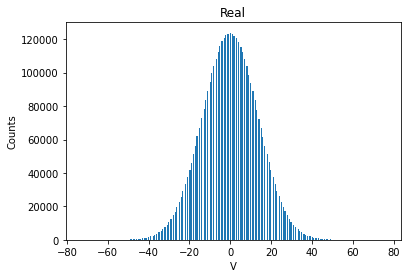

13.580996241059605


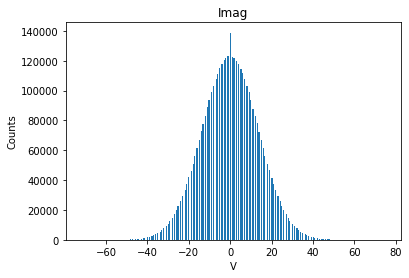

13.581680154851574
Target sigma is 13.589148804608305.


In [64]:
# Digitizing
v_q = digitizer.quantize(v)

# Channelizing
v_c = filterbank.channelize(v_q)

# Requantizing
v_rq = requantizer.quantize(v_c)

plt.hist(get_numpy(v_rq.real.flatten()), bins=2**num_bits)
plt.title('Real')
plt.xlabel('V')
plt.ylabel('Counts')
plt.show()
print(np.std(get_numpy(v_rq.real.flatten())))

plt.hist(get_numpy(v_rq.imag.flatten()), bins=2**num_bits)
plt.title('Imag')
plt.xlabel('V')
plt.ylabel('Counts')
plt.show()
print(np.std(get_numpy(v_rq.imag.flatten())))

sigma = target_fwhm / (2 * np.sqrt(2 * np.log(2)))
print(f'Target sigma is {sigma}.')

## Fine channelization
Here we dive into a simple implementation of fine channelization.

Shape before FFT (num_chans, t_chans, fftlength): (64, 16, 512)

Variance of powers in channel 2 before FFT: 370.54432137395787
Variance of powers in every channel before FFT: 370.8358691763784 

Shape after FFT: (64, 16, 512)
Shape of XX_sub: (64, 16, 128)


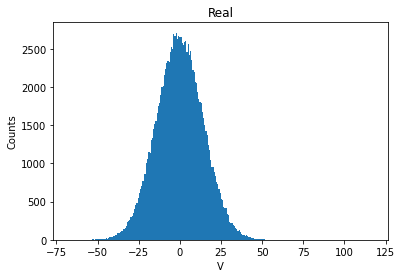

-0.011365092898503517
14.240548998164083


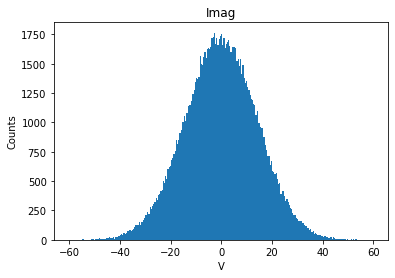

-0.03864889238318764
14.287116209922104

XX_psd (mean, std): 368.0581626892089 381.5125267931055
XX_psd shape: (64, 16, 512)
XX_psd_sub (mean, std): 406.9165482671501 411.78350622925495
XX_psd_sub shape: (64, 16, 128)
Sub array mean is 1.1055767525817748 times the overall mean

Shape after concatenation: (16, 32768)
Shape after integration: (16, 32768)


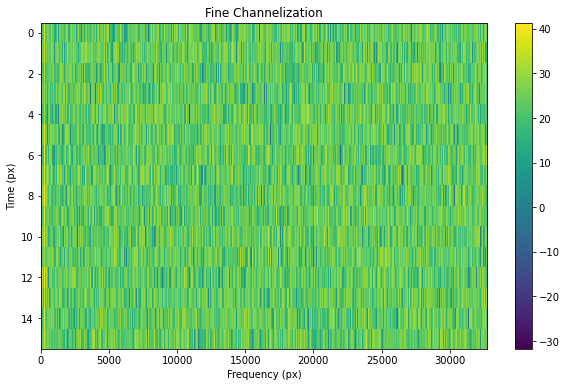

In [65]:
int_factor=1

# Truncate coarse channels to the first 64.
pfb_voltages = v_rq[:, 0:64]

X_samples = pfb_voltages.T
X_samples = X_samples[:, :(X_samples.shape[1] // fftlength) * fftlength]
X_samples = X_samples.reshape((X_samples.shape[0], X_samples.shape[1] // fftlength, fftlength))
print(f"Shape before FFT (num_chans, t_chans, fftlength): {X_samples.shape}\n")

print('Variance of powers in channel 2 before FFT:', xp.std(xp.abs(X_samples[2, :, :])**2))
print('Variance of powers in every channel before FFT:', xp.std(xp.abs(X_samples[:, :, :])**2),'\n')

XX = xp.fft.fft(X_samples, fftlength, axis=2) / fftlength**0.5
XX = xp.fft.fftshift(XX, axes=2)
XX_psd = xp.abs(XX)**2 #/ fftlength

print(f"Shape after FFT: {XX.shape}")

# XX_sub = XX[:, :, :]
XX_sub = XX[:, :, 3*fftlength//8:5*fftlength//8]
XX_psd_sub = xp.abs(XX_sub)**2
print(f"Shape of XX_sub: {XX_sub.shape}")

plt.hist(get_numpy(XX_sub.real.flatten()), bins=2**num_bits)
plt.title('Real')
plt.xlabel('V')
plt.ylabel('Counts')
plt.show()
print(np.mean(get_numpy(XX_sub.real.flatten())))

print(np.std(get_numpy(XX_sub.real.flatten())))

plt.hist(get_numpy(XX_sub.imag.flatten()), bins=2**num_bits)
plt.title('Imag')
plt.xlabel('V')
plt.ylabel('Counts')
plt.show()
print(np.mean(get_numpy(XX_sub.imag.flatten())))
print(np.std(get_numpy(XX_sub.imag.flatten())))
print()

print('XX_psd (mean, std):', xp.mean(XX_psd), xp.std(XX_psd))
print(f"XX_psd shape: {XX_psd.shape}")

print('XX_psd_sub (mean, std):', xp.mean(XX_psd_sub), xp.std(XX_psd_sub))
print(f"XX_psd_sub shape: {XX_psd_sub.shape}")

print(f'Sub array mean is {xp.mean(XX_psd_sub)/xp.mean(XX_psd)} times the overall mean\n')

XX_psd = xp.concatenate(XX_psd, axis=1)
print('Shape after concatenation:', XX_psd.shape)

# Integrate over time, trimming if necessary
XX_psd = XX_psd[:(XX_psd.shape[0] // int_factor) * int_factor]
XX_psd = XX_psd.reshape(XX_psd.shape[0] // int_factor, int_factor, XX_psd.shape[1])
XX_psd = XX_psd.sum(axis=1)

print('Shape after integration:', XX_psd.shape)

plt.figure(figsize=(10, 6))
plt.imshow(db(get_numpy(XX_psd)), 
           cmap='viridis', 
           aspect='auto', 
           interpolation='none')
plt.colorbar()
plt.xlabel("Frequency (px)")
plt.ylabel("Time (px)")
plt.title("Fine Channelization")
plt.show()

Integrating over time:

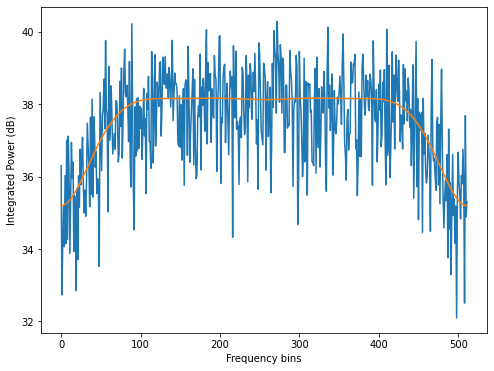

In [75]:
plt.figure(figsize=(8, 6))
A = np.sum(get_numpy(XX_psd), axis=0)[2*fftlength:3*fftlength]
plt.plot(db(A))
B = xp.concatenate([half_coarse_chan[::-1], half_coarse_chan])/xp.mean(half_coarse_chan) * requantizer.target_sigma**2 * 2 * XX_psd.shape[0]
B = get_numpy(B)
plt.plot(db(B))
plt.xlabel("Frequency bins")
plt.ylabel("Integrated Power (dB)")
plt.show()

In [84]:
fftlength

512

In [94]:
fftlength * (2.2 - 0.5)

870.4000000000001

# ONLY NOISE
Seeding to get consistent results:

Shape after integration: (64, 32768)


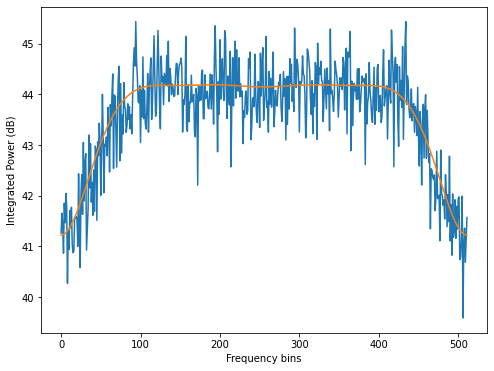

In [57]:
sample_rate = 3e9
antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=0*u.GHz,
                              ascending=True,
                              num_pols=1,
                              seed=0)

antenna.x.add_noise(v_mean=0, 
                    v_std=1)

###############################

num_windows = 1024 * 4
num_samples = num_taps * num_branches * (num_windows + 1)

v = antenna.x.get_samples(num_samples)


# Digitizing
v_q = digitizer.quantize(v)

# Channelizing
v_c = filterbank.channelize(v_q)

# Requantizing
v_rq = requantizer.quantize(v_c)

int_factor=1

# Truncate coarse channels to the first 64.
pfb_voltages = v_rq[:, 0:64]

X_samples = pfb_voltages.T
X_samples = X_samples[:, :(X_samples.shape[1] // fftlength) * fftlength]
X_samples = X_samples.reshape((X_samples.shape[0], X_samples.shape[1] // fftlength, fftlength))

XX = xp.fft.fft(X_samples, fftlength, axis=2) / fftlength**0.5
XX = xp.fft.fftshift(XX, axes=2)
XX_psd = xp.abs(XX)**2 #/ fftlength

XX_psd = xp.concatenate(XX_psd, axis=1)

# Integrate over time, trimming if necessary
XX_psd = XX_psd[:(XX_psd.shape[0] // int_factor) * int_factor]
XX_psd = XX_psd.reshape(XX_psd.shape[0] // int_factor, int_factor, XX_psd.shape[1])
XX_psd = XX_psd.sum(axis=1)

print('Shape after integration:', XX_psd.shape)

plt.figure(figsize=(8, 6))
coarse_chan = 2
A_n = np.sum(get_numpy(XX_psd), axis=0)[coarse_chan*fftlength:(coarse_chan+1)*fftlength]
plt.plot(db(A_n))
B = xp.concatenate([half_coarse_chan[::-1], half_coarse_chan])/xp.mean(half_coarse_chan) * requantizer.target_sigma**2 * 2 * XX_psd.shape[0]
B = get_numpy(B)
plt.plot(db(B))
plt.xlabel("Frequency bins")
plt.ylabel("Integrated Power (dB)")
plt.show()

Shape before FFT (num_chans, t_chans, fftlength): (64, 64, 512)

Variance of powers in channel 2 before FFT: 373.7062689881842
Variance of powers in every channel before FFT: 373.311395784047 

Shape after FFT: (64, 64, 512)
Shape of XX_sub: (64, 64, 128)


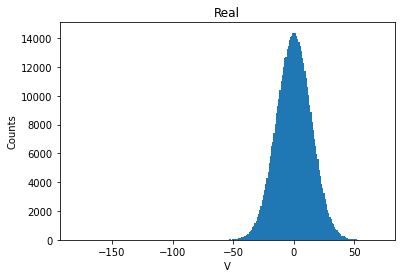

-0.05010720931697439
14.386506878323898


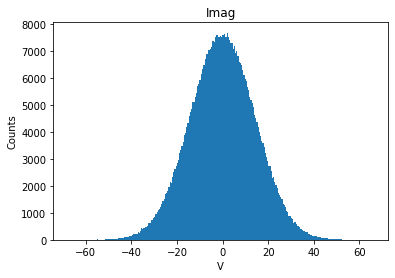

0.003165014598695646
14.300140565447464

XX_psd (mean, std): 370.0525598526001 397.03018743641746
XX_psd shape: (64, 64, 512)
XX_psd_sub (mean, std): 411.4681211013598 465.0843948230109
XX_psd_sub shape: (64, 64, 128)
Sub array mean is 1.1119180509526982 times the overall mean

Shape after concatenation: (64, 32768)
Shape after integration: (64, 32768)


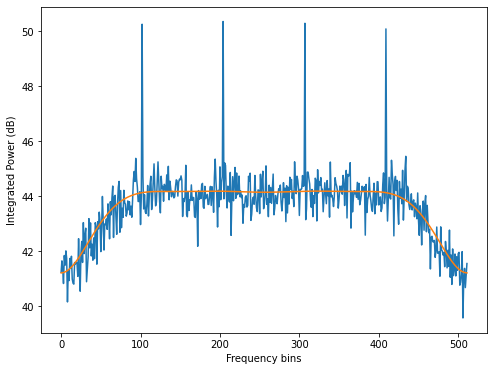

In [111]:
sample_rate = 3e9
antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=0*u.GHz,
                              ascending=True,
                              num_pols=1,
                              seed=0)

antenna.x.add_noise(v_mean=0, 
                    v_std=1)

antenna.x.add_constant_signal(f_start=chan_bw / fftlength * int(fftlength * (2.2 - 0.5)), 
                              drift_rate=0, 
                              level=0.005,
                              mode='level')

antenna.x.add_constant_signal(f_start=chan_bw / fftlength * int(fftlength * (2.4 - 0.5)), 
                              drift_rate=0, 
                              level=0.005,
                              mode='level')

antenna.x.add_constant_signal(f_start=chan_bw / fftlength * int(fftlength * (2.6 - 0.5)), 
                              drift_rate=0, 
                              level=0.005,
                              mode='level')

antenna.x.add_constant_signal(f_start=chan_bw / fftlength * int(fftlength * (2.8 - 0.5)), 
                              drift_rate=0, 
                              level=0.005,
                              mode='level')



###############################

num_windows = 1024 * 4
num_samples = num_taps * num_branches * (num_windows + 1)

v = antenna.x.get_samples(num_samples)


# Digitizing
v_q = digitizer.quantize(v)

# Channelizing
v_c = filterbank.channelize(v_q)

# Requantizing
v_rq = requantizer.quantize(v_c)

int_factor=1

# Truncate coarse channels to the first 64.
pfb_voltages = v_rq[:, 0:64]

X_samples = pfb_voltages.T
X_samples = X_samples[:, :(X_samples.shape[1] // fftlength) * fftlength]
X_samples = X_samples.reshape((X_samples.shape[0], X_samples.shape[1] // fftlength, fftlength))
print(f"Shape before FFT (num_chans, t_chans, fftlength): {X_samples.shape}\n")

print('Variance of powers in channel 2 before FFT:', xp.std(xp.abs(X_samples[2, :, :])**2))
print('Variance of powers in every channel before FFT:', xp.std(xp.abs(X_samples[:, :, :])**2),'\n')

XX = xp.fft.fft(X_samples, fftlength, axis=2) / fftlength**0.5
XX = xp.fft.fftshift(XX, axes=2)
XX_psd = xp.abs(XX)**2 

print(f"Shape after FFT: {XX.shape}")

# XX_sub = XX[:, :, :]
XX_sub = XX[:, :, 3*fftlength//8:5*fftlength//8]
XX_psd_sub = xp.abs(XX_sub)**2
print(f"Shape of XX_sub: {XX_sub.shape}")

plt.hist(get_numpy(XX_sub.real.flatten()), bins=2**num_bits)
plt.title('Real')
plt.xlabel('V')
plt.ylabel('Counts')
plt.show()
print(np.mean(get_numpy(XX_sub.real.flatten())))

print(np.std(get_numpy(XX_sub.real.flatten())))

plt.hist(get_numpy(XX_sub.imag.flatten()), bins=2**num_bits)
plt.title('Imag')
plt.xlabel('V')
plt.ylabel('Counts')
plt.show()
print(np.mean(get_numpy(XX_sub.imag.flatten())))
print(np.std(get_numpy(XX_sub.imag.flatten())))
print()

print('XX_psd (mean, std):', xp.mean(XX_psd), xp.std(XX_psd))
print(f"XX_psd shape: {XX_psd.shape}")

print('XX_psd_sub (mean, std):', xp.mean(XX_psd_sub), xp.std(XX_psd_sub))
print(f"XX_psd_sub shape: {XX_psd_sub.shape}")

print(f'Sub array mean is {xp.mean(XX_psd_sub)/xp.mean(XX_psd)} times the overall mean\n')

XX_psd = xp.concatenate(XX_psd, axis=1)
print('Shape after concatenation:', XX_psd.shape)

# Integrate over time, trimming if necessary
XX_psd = XX_psd[:(XX_psd.shape[0] // int_factor) * int_factor]
XX_psd = XX_psd.reshape(XX_psd.shape[0] // int_factor, int_factor, XX_psd.shape[1])
XX_psd = XX_psd.sum(axis=1)

print('Shape after integration:', XX_psd.shape)

plt.figure(figsize=(8, 6))
coarse_chan = 2
A = np.sum(get_numpy(XX_psd), axis=0)[coarse_chan*fftlength:(coarse_chan+1)*fftlength]
plt.plot(db(A))
B = xp.concatenate([half_coarse_chan[::-1], half_coarse_chan])/xp.mean(half_coarse_chan) * requantizer.target_sigma**2 * 2 * XX_psd.shape[0]
B = get_numpy(B)
plt.plot(db(B))
plt.xlabel("Frequency bins")
plt.ylabel("Integrated Power (dB)")
plt.show()

In [112]:
idx = np.argsort(A)[::-1][:4]
idx

array([204, 307, 102, 409])

In [113]:
A[idx]

array([108469.29181722, 106839.70498059, 105981.14933635, 101918.18893732])

In [114]:
A[idx] - B[idx]

array([82250.12326995, 80620.53643332, 80075.2842274 , 76012.32382837])

In [115]:
B[idx]

array([26219.16854728, 26219.16854728, 25905.86510895, 25905.86510895])

In [116]:
A_n[idx]

array([25962.14966945, 25050.33091956, 22775.79601675, 25761.13300138])

In [117]:
A[idx] - A_n[idx]

array([82507.14214777, 81789.37406103, 83205.3533196 , 76157.05593594])

In [118]:
So how to go from 0.005 to these values, at least ballpark?

Object `ballpark` not found.


In [123]:
(A[idx] - A_n[idx]) / get_numpy(max_mean_ratio)

array([74319.30697711, 73672.76868493, 74948.22914145, 68599.38995873])

In [126]:
(A[idx] - A_n[idx]) / get_numpy(max_mean_ratio) / 64

array([1161.23917152, 1151.1370107 , 1171.06608034, 1071.86546811])

In [124]:
0.005**2

2.5e-05

In [127]:
actual_num_samples = num_taps * num_branches * num_windows
actual_num_samples

33554432

In [130]:
1 / actual_num_samples**0.5

0.00017263349150062194

In [139]:
0.005**2 * actual_num_samples * requantizer.target_sigma**2 * 2 

array(51636.06682266)

In [25]:
sample_rate = 3e9
antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=0*u.GHz,
                              ascending=True,
                              num_pols=1,
                              seed=0)

antenna.x.add_noise(v_mean=0, 
                    v_std=1)

antenna.x.add_constant_signal(f_start=chan_bw / fftlength * (fftlength*1.5 + 100), 
                              drift_rate=0, 
                              level=0.005,
                              mode='level')

antenna.x.add_constant_signal(f_start=chan_bw / fftlength * (fftlength*1.5 + 200), 
                              drift_rate=0, 
                              level=0.005,
                              mode='level')

antenna.x.add_constant_signal(f_start=chan_bw / fftlength * (fftlength*1.5 + 300), 
                              drift_rate=0, 
                              level=0.005,
                              mode='level')

antenna.x.add_constant_signal(f_start=chan_bw / fftlength * (fftlength*1.5 + 400), 
                              drift_rate=0, 
                              level=0.005,
                              mode='level')

###############################

ITERATIONS = 100

vals = np.zeros((ITERATIONS, 4))
for i in range(ITERATIONS):


    num_windows = 1024 * 4
    num_samples = num_taps * num_branches * (num_windows + 1)

    v = antenna.x.get_samples(num_samples)


    # Digitizing
    v_q = digitizer.quantize(v)

    # Channelizing
    v_c = filterbank.channelize(v_q)

    # Requantizing
    v_rq = requantizer.quantize(v_c)

    int_factor=1

    # Truncate coarse channels to the first 64.
    pfb_voltages = v_rq[:, 0:64]

    X_samples = pfb_voltages.T
    X_samples = X_samples[:, :(X_samples.shape[1] // fftlength) * fftlength]
    X_samples = X_samples.reshape((X_samples.shape[0], X_samples.shape[1] // fftlength, fftlength))

    XX = xp.fft.fft(X_samples, fftlength, axis=2) / fftlength**0.5
    XX = xp.fft.fftshift(XX, axes=2)
    XX_psd = xp.abs(XX)**2 #/ fftlength

    XX_psd = xp.concatenate(XX_psd, axis=1)

    # Integrate over time, trimming if necessary
    XX_psd = XX_psd[:(XX_psd.shape[0] // int_factor) * int_factor]
    XX_psd = XX_psd.reshape(XX_psd.shape[0] // int_factor, int_factor, XX_psd.shape[1])
    XX_psd = XX_psd.sum(axis=1)

    coarse_chan = 2
    A = np.sum(get_numpy(XX_psd), axis=0)[coarse_chan*fftlength:(coarse_chan+1)*fftlength]
    
    vals[i] = A[[100, 200, 300, 400]]
    
vals = np.mean(vals, axis=0)
vals

array([108063.34301061, 112018.37795   , 112104.08310804, 111553.41656916])

In [26]:
B = xp.concatenate([half_coarse_chan[::-1], half_coarse_chan])/xp.mean(half_coarse_chan) * requantizer.target_sigma**2 * 2 * XX_psd.shape[0]
B = get_numpy(B)

In [27]:
vals - B[[100, 200, 300, 400]]

array([82219.75233508, 85787.70082283, 85914.11619566, 85464.01911586])

In [28]:
B[[100, 200, 300, 400]]

array([25843.59067553, 26230.67712717, 26189.96691238, 26089.39745331])

In [40]:
(vals - B[[100, 200, 300, 400]]) / B[[100, 200, 300, 400]]

array([3.18143687, 3.27051034, 3.28042095, 3.27581422])

In [29]:
0.005**2

2.5e-05

In [30]:
actual_num_samples = num_taps * num_branches * num_windows
actual_num_samples

33554432

In [31]:
1 / actual_num_samples**0.5

0.00017263349150062194

In [32]:
0.005**2 * actual_num_samples * requantizer.target_sigma**2 * 2 

array(309816.40093597)

In [33]:
(0.005 / (1 / actual_num_samples**0.5))**2

838.8608000000003

In [34]:
requantizer.target_sigma**2 * 2

array(369.32993047)

In [35]:
(0.005 / (1 / actual_num_samples**0.5))**2 * requantizer.target_sigma**2

array(154908.20046799)

In [36]:
vars(digitizer)

{'target_fwhm': 32,
 'target_sigma': array(13.5891488),
 'num_bits': 8,
 'data_sigma': array(1.00237144),
 'data_mean': array(0.00372058)}

In [39]:
factor = digitizer.target_sigma / digitizer.data_sigma
factor

array(13.55699913)

In [42]:
(0.005 * factor)**2

array(0.00459481)

In [44]:
(0.005 / (1 / actual_num_samples**0.5))**2 *

array(171161.83338498)

In [45]:
requantizer.target_sigma**2 * 2 * max_mean_ratio

array(410.01939216)

In [51]:
XX_psd.shape

(64, 32768)

In [58]:
D = XX_psd[:, coarse_chan*fftlength:(coarse_chan+1)*fftlength][:, 3*fftlength//8:5*fftlength//8]

np.mean(D/np.mean(D)*2), np.var(D/np.mean(D)*2)

(array(2.), array(4.16872398))

In [60]:
np.mean(D), np.std(D)

(array(405.18999517), array(413.64738973))

real v: 0.00011362329482739239 0.9999925757309418
power before channelize: 0.9999851644272565 1.4138681858135895
point 1: 0.041475303003722236 13.670098390387723
point 2: 0.0414569698236312 13.021433304537455
real part of channelized v: 0.0024298216140165394 9.226175846401315
power after channelize: 169.56126155797227 169.87645244980487
power after fine channelize: 369.23221349716187 381.08287541129397
Shape after integration: (64, 32768)


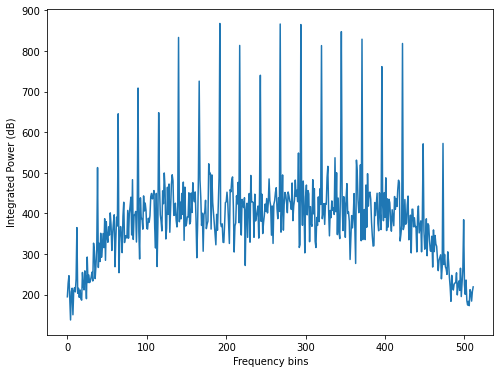

(382.9037475585937, 867.7830970100844)

In [8]:
###############################

sample_rate = 3e9
num_taps = 8
num_branches = 1024

chan_bw = sample_rate / num_branches

digitizer = stg.voltage.RealQuantizer(target_fwhm=32,
                                      num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

num_bits = 8
target_fwhm = 32*2**num_bits/2**8
requantizer = stg.voltage.ComplexQuantizer(target_fwhm=target_fwhm,
                                           num_bits=num_bits)


fftlength = 512

data = xp.zeros(num_branches * fftlength)
data[:num_taps*num_branches] = filterbank.window
h = xp.fft.fft(data)

half_coarse_chan = (xp.abs(h)**2)[:fftlength//2]+(xp.abs(h)**2)[fftlength//2:fftlength][::-1]

max_mean_ratio = xp.max(half_coarse_chan) / xp.mean(half_coarse_chan)

###############################

antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=0*u.GHz,
                              ascending=True,
                              num_pols=1,
                              seed=None)

antenna.x.add_noise(v_mean=0, 
                    v_std=1)

for i in range(20):
    antenna.x.add_constant_signal(f_start=chan_bw / fftlength * int(fftlength * (2 + i/20+0.025 - 0.5)), 
                              drift_rate=0, 
                              level=1 / (num_branches * fftlength / 4)**0.5 * 1**0.5,
                              mode='level')


# antenna.x.add_constant_signal(f_start=chan_bw / fftlength * int(fftlength * (2.5 - 0.5)), 
#                               drift_rate=0, 
#                               level=1 / (num_branches * fftlength / 4)**0.5,
#                               mode='level')

###############################

num_windows = 1024 * 4
num_samples = num_taps * num_branches * (num_windows + 1)

v = antenna.x.get_samples(num_samples)

print('real v:', xp.mean(v), xp.std(v))
print('power before channelize:', xp.mean(xp.abs(v)**2), xp.std(xp.abs(v)**2))

# Digitizing
v = digitizer.quantize(v)

# Channelizing
v = filterbank.channelize(v)

print('real part of channelized v:', xp.mean(v.real), xp.std(v.real))
print('power after channelize:', xp.mean(xp.abs(v)**2), xp.std(xp.abs(v)**2))

# Requantizing
v = requantizer.quantize(v)

int_factor=1

# Truncate coarse channels to the first 64.
pfb_voltages = v[:, 0:64]

X_samples = pfb_voltages.T
X_samples = X_samples[:, :(X_samples.shape[1] // fftlength) * fftlength]
X_samples = X_samples.reshape((X_samples.shape[0], X_samples.shape[1] // fftlength, fftlength))

XX = xp.fft.fft(X_samples, fftlength, axis=2) / fftlength**0.5
XX = xp.fft.fftshift(XX, axes=2)
XX_psd = xp.abs(XX)**2 
print('power after fine channelize:', xp.mean(XX_psd), xp.std(XX_psd))

XX_psd = xp.concatenate(XX_psd, axis=1)

# Integrate over time, trimming if necessary
XX_psd = XX_psd[:(XX_psd.shape[0] // int_factor) * int_factor]
XX_psd = XX_psd.reshape(XX_psd.shape[0] // int_factor, int_factor, XX_psd.shape[1])
XX_psd = XX_psd.sum(axis=1)

print('Shape after integration:', XX_psd.shape)

plt.figure(figsize=(8, 6))
coarse_chan = 2
A_n = np.sum(get_numpy(XX_psd), axis=0)[coarse_chan*fftlength:(coarse_chan+1)*fftlength] / XX_psd.shape[0] 
plt.plot((A_n))
B = xp.concatenate([half_coarse_chan[::-1], half_coarse_chan])/xp.mean(half_coarse_chan) / (max_mean_ratio) #* XX_psd.shape[0] 
B = get_numpy(B)
# plt.plot((B))
# plt.plot((11*B))
plt.xlabel("Frequency bins")
plt.ylabel("Integrated Power (dB)")
plt.show()

np.mean(A_n), np.max(A_n)

In [12]:
np.sort(A_n)[::-1][:20]

array([11.93477818, 11.47317105, 11.37290691, 11.28265145, 11.19857944,
       11.18585049, 11.1507284 , 11.06830278, 10.97373267, 10.84024716,
       10.54729618, 10.53508881, 10.35919761, 10.00885955,  9.57168404,
        9.22992197,  7.10886458,  6.75923696,  4.59495014,  4.44389356])

In [64]:
max_mean_ratio

array(1.11018559)

In [11]:
np.mean(A_n), np.max(A_n)

(256.03242261385395, 131088.60037829322)

In [20]:
num_branches * fftlength / 4

131072.0

In [65]:
256*512

131072

In [26]:
xp.mean(filterbank.window)

array(0.00012207)

In [27]:
xp.mean(filterbank.window)*1024*8

array(1.)

In [28]:
8.652452402984126e-07 * 64

5.5375695379098403e-05

In [31]:
xp.mean(filterbank.window)

array(1.)

In [11]:
filterbank.window

(8192,)

In [15]:
xp.reshape(filterbank.window, (8, 1024)).sum(axis=0).mean()

array(8.)

In [18]:
1/2**0.5

0.7071067811865475

In [23]:
noise = np.random.normal(0, 1, 1024)
sine = np.sin(np.linspace(0, 16*2*np.pi, 1024))
print(np.mean(noise), np.std(noise))

-0.009936845054199072 1.026579376446604


In [40]:
Noise = np.fft.rfft(noise, 1024)/1024**0.5
print(np.mean(Noise.real), np.std(Noise.real))

-0.013354572552176569 0.685026194576959


In [41]:
print(np.mean(np.abs(Noise)**2), np.std(np.abs(Noise)**2))

0.9831040957331446 0.9993067024061856


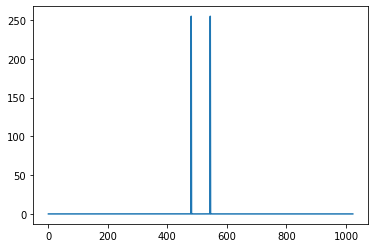

In [59]:
sine = np.sin(np.linspace(0, 32*2*np.pi, 1024))
xx = np.fft.fft(sine) / 1024**0.5
xx = np.fft.fftshift(xx)
plt.plot(np.abs(xx)**2)
plt.show()

In [60]:
sine.shape

(1024,)

In [61]:
np.sum(sine**2)

511.50000000000006

In [62]:
(np.abs(xx)**2).sum()

511.5

In [10]:
13.6**2 * 2 * 1.11

410.6112

real v: -0.00024391243008375094 0.9999270546014015
power before channelize: 0.9998541740171085 1.4135224995608469
point 1: -0.20694055387326094 13.731665287213701
point 2: -0.2069639073181987 13.080349868571258
real part of channelized v: -0.011841735045791054 9.26993775680566
power after channelize: 171.1809361468342 171.63323474384597
power after fine channelize: 371.2237763404846 466.95363341905176
Shape after integration: (64, 32768)


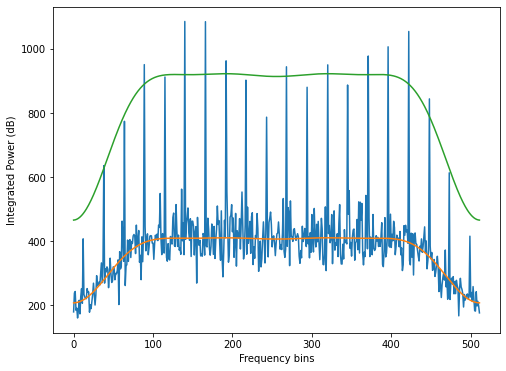

(387.86114501953125, 1085.7096412112)

In [7]:
###############################

sample_rate = 3e9
num_taps = 8
num_branches = 1024

chan_bw = sample_rate / num_branches

digitizer = stg.voltage.RealQuantizer(target_fwhm=32,
                                      num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

num_bits = 8
target_fwhm = 32*2**num_bits/2**8
requantizer = stg.voltage.ComplexQuantizer(target_fwhm=target_fwhm,
                                           num_bits=num_bits)


fftlength = 512

data = xp.zeros(num_branches * fftlength)
data[:num_taps*num_branches] = filterbank.window
h = xp.fft.fft(data)

half_coarse_chan = (xp.abs(h)**2)[:fftlength//2]+(xp.abs(h)**2)[fftlength//2:fftlength][::-1]

max_mean_ratio = xp.max(half_coarse_chan) / xp.mean(half_coarse_chan)

###############################

antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=0*u.GHz,
                              ascending=True,
                              num_pols=1,
                              seed=None)

antenna.x.add_noise(v_mean=0, 
                    v_std=1)


num_pols = 1
int_factor = 1
chi_df = 2 * num_pols * int_factor
main_mean = (requantizer.target_sigma)**2 * chi_df * max_mean_ratio
SNR = xp.sqrt(2 / chi_df) / 64**0.5

for i in range(20):
    antenna.x.add_constant_signal(f_start=chan_bw / fftlength * int(fftlength * (2 + i/20+0.025 - 0.5)), 
                              drift_rate=0, 
                              level=1 / (num_branches * fftlength / 4)**0.5 * (10*SNR)**0.5,
                              mode='level')


# antenna.x.add_constant_signal(f_start=chan_bw / fftlength * int(fftlength * (2.5 - 0.5)), 
#                               drift_rate=0, 
#                               level=1 / (num_branches * fftlength / 4)**0.5,
#                               mode='level')

###############################

num_windows = 1024 * 4
num_samples = num_taps * num_branches * (num_windows + 1)

v = antenna.x.get_samples(num_samples)

print('real v:', xp.mean(v), xp.std(v))
print('power before channelize:', xp.mean(xp.abs(v)**2), xp.std(xp.abs(v)**2))

# Digitizing
v = digitizer.quantize(v)

# Channelizing
v = filterbank.channelize(v)

print('real part of channelized v:', xp.mean(v.real), xp.std(v.real))
print('power after channelize:', xp.mean(xp.abs(v)**2), xp.std(xp.abs(v)**2))

# Requantizing
v = requantizer.quantize(v)

int_factor=1

# Truncate coarse channels to the first 64.
pfb_voltages = v[:, 0:64]

X_samples = pfb_voltages.T
X_samples = X_samples[:, :(X_samples.shape[1] // fftlength) * fftlength]
X_samples = X_samples.reshape((X_samples.shape[0], X_samples.shape[1] // fftlength, fftlength))

XX = xp.fft.fft(X_samples, fftlength, axis=2) / fftlength**0.5
XX = xp.fft.fftshift(XX, axes=2)
XX_psd = xp.abs(XX)**2 
print('power after fine channelize:', xp.mean(XX_psd), xp.std(XX_psd))

XX_psd = xp.concatenate(XX_psd, axis=1)

# Integrate over time, trimming if necessary
XX_psd = XX_psd[:(XX_psd.shape[0] // int_factor) * int_factor]
XX_psd = XX_psd.reshape(XX_psd.shape[0] // int_factor, int_factor, XX_psd.shape[1])
XX_psd = XX_psd.sum(axis=1)

print('Shape after integration:', XX_psd.shape)

plt.figure(figsize=(8, 6))
coarse_chan = 2
A_n = np.sum(get_numpy(XX_psd), axis=0)[coarse_chan*fftlength:(coarse_chan+1)*fftlength] / XX_psd.shape[0] 
plt.plot((A_n))
B = xp.concatenate([half_coarse_chan[::-1], half_coarse_chan])/xp.mean(half_coarse_chan) / (max_mean_ratio) * main_mean #* XX_psd.shape[0] 
B = get_numpy(B)
plt.plot((B))
plt.plot((B*(1+get_numpy(10*SNR))))
plt.xlabel("Frequency bins")
plt.ylabel("Integrated Power (dB)")
plt.show()

np.mean(A_n), np.max(A_n)

In [9]:
num_taps * num_windows / fftlength

64.0

In [17]:
512-128

384

In [4]:
A_n[128:384].mean()

409.45071959859297

In [5]:
A_n[128:384].std()

54.19786949926559

real v: 0.00015687770574348165 1.0001714215716808
power before channelize: 1.0003428971393309 1.4145895511780624
point 1: 0.00015687770574348165 1.0001714215716808
point 2: 0.0001599760584047457 0.9527210939012194
real part of channelized v: 1.3179749980059268e-05 0.6750672736412059
power after channelize: 0.9076683255258507 0.9092980352492912
power after fine channelize: 0.9094001035427228 0.9396876045502827
Shape after integration: (32, 32768)


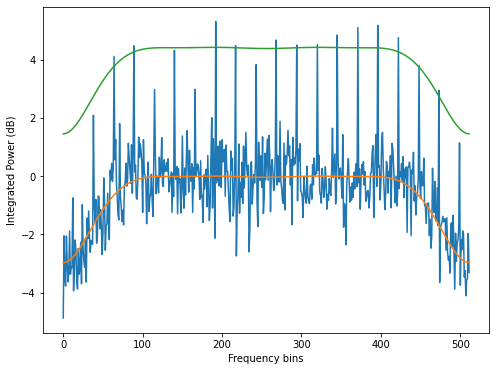

(0.9725920796004115, 3.395990681584435)

In [26]:
###############################
num_windows = 1024 * 2


sample_rate = 3e9
num_taps = 8
num_branches = 1024

chan_bw = sample_rate / num_branches

digitizer = stg.voltage.RealQuantizer(target_fwhm=32,
                                      num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

num_bits = 8
target_fwhm = 32*2**num_bits/2**8
requantizer = stg.voltage.ComplexQuantizer(target_fwhm=target_fwhm,
                                           num_bits=num_bits)


fftlength = 512

data = xp.zeros(num_branches * fftlength)
data[:num_taps*num_branches] = filterbank.window
h = xp.fft.fft(data)

half_coarse_chan = (xp.abs(h)**2)[:fftlength//2]+(xp.abs(h)**2)[fftlength//2:fftlength][::-1]

max_mean_ratio = xp.max(half_coarse_chan) / xp.mean(half_coarse_chan)

###############################

antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=0*u.GHz,
                              ascending=True,
                              num_pols=1,
                              seed=None)

antenna.x.add_noise(v_mean=0, 
                    v_std=1)


num_pols = 1
int_factor = 1
chi_df = 2 * num_pols * int_factor
main_mean = (requantizer.target_sigma)**2 * chi_df * max_mean_ratio
tchans_fine = num_taps * num_windows / fftlength
SNR = xp.sqrt(2 / chi_df) / tchans_fine**0.5
num_SNR = 10

for i in range(20):
    antenna.x.add_constant_signal(f_start=chan_bw / fftlength * int(fftlength * (2 + i/20+0.025 - 0.5)), 
                              drift_rate=0, 
                              level=1 / (num_branches * fftlength / 4)**0.5 * (num_SNR*SNR)**0.5,
                              mode='level')


# antenna.x.add_constant_signal(f_start=chan_bw / fftlength * int(fftlength * (2.5 - 0.5)), 
#                               drift_rate=0, 
#                               level=1 / (num_branches * fftlength / 4)**0.5,
#                               mode='level')

###############################


num_samples = num_taps * num_branches * (num_windows + 1)

v = antenna.x.get_samples(num_samples)

print('real v:', xp.mean(v), xp.std(v))
print('power before channelize:', xp.mean(xp.abs(v)**2), xp.std(xp.abs(v)**2))

# Digitizing
# v = digitizer.quantize(v)

# Channelizing
v = filterbank.channelize(v)

print('real part of channelized v:', xp.mean(v.real), xp.std(v.real))
print('power after channelize:', xp.mean(xp.abs(v)**2), xp.std(xp.abs(v)**2))

# Requantizing
# v = requantizer.quantize(v)


# Truncate coarse channels to the first 64.
pfb_voltages = v[:, 0:64]

X_samples = pfb_voltages.T
X_samples = X_samples[:, :(X_samples.shape[1] // fftlength) * fftlength]
X_samples = X_samples.reshape((X_samples.shape[0], X_samples.shape[1] // fftlength, fftlength))

XX = xp.fft.fft(X_samples, fftlength, axis=2) / fftlength**0.5
XX = xp.fft.fftshift(XX, axes=2)
XX_psd = xp.abs(XX)**2 
print('power after fine channelize:', xp.mean(XX_psd), xp.std(XX_psd))

XX_psd = xp.concatenate(XX_psd, axis=1)

# Integrate over time, trimming if necessary
XX_psd = XX_psd[:(XX_psd.shape[0] // int_factor) * int_factor]
XX_psd = XX_psd.reshape(XX_psd.shape[0] // int_factor, int_factor, XX_psd.shape[1])
XX_psd = XX_psd.sum(axis=1)

print('Shape after integration:', XX_psd.shape)

plt.figure(figsize=(8, 6))
coarse_chan = 2
A_n = np.sum(get_numpy(XX_psd), axis=0)[coarse_chan*fftlength:(coarse_chan+1)*fftlength] / XX_psd.shape[0] 
plt.plot(db(A_n))
B = xp.concatenate([half_coarse_chan[::-1], half_coarse_chan])/xp.mean(half_coarse_chan) / (max_mean_ratio) * int_factor#* main_mean #* XX_psd.shape[0] 
B = get_numpy(B)
plt.plot(db(B))
plt.plot(db(B*(1+get_numpy(num_SNR*SNR))))
plt.xlabel("Frequency bins")
plt.ylabel("Integrated Power (dB)")
plt.show()

np.mean(A_n), np.max(A_n)

In [30]:
 (2 + i/20+0.025 - 0.5)

2.475

real v: -5.633049052128462e-09 0.008735158904051436
power before channelize: 7.630300107906085e-05 0.0002722136003963734
point 1: -5.633049052128462e-09 0.008735158904051436
point 2: 4.903401755503594e-11 0.008320057099582829
real part of channelized v: -9.410129899922771e-08 0.005895800968818764
power after channelize: 6.908841475688422e-05 0.005541226327687184
power after fine channelize: 0.0005537868245348459 0.019763310048154875
Shape after integration: (32, 32768)


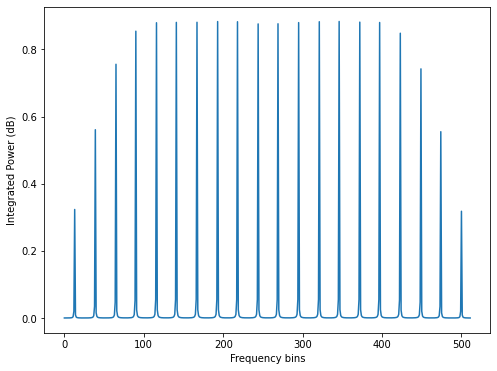

(0.034640617100959864, 0.8833304777477904)

In [43]:
###############################
num_windows = 1024 * 2


sample_rate = 3e9
num_taps = 8
num_branches = 1024

chan_bw = sample_rate / num_branches

digitizer = stg.voltage.RealQuantizer(target_fwhm=32,
                                      num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

num_bits = 8
target_fwhm = 32*2**num_bits/2**8
requantizer = stg.voltage.ComplexQuantizer(target_fwhm=target_fwhm,
                                           num_bits=num_bits)


fftlength = 512

data = xp.zeros(num_branches * fftlength)
data[:num_taps*num_branches] = filterbank.window
h = xp.fft.fft(data)

half_coarse_chan = (xp.abs(h)**2)[:fftlength//2]+(xp.abs(h)**2)[fftlength//2:fftlength][::-1]

max_mean_ratio = xp.max(half_coarse_chan) / xp.mean(half_coarse_chan)

###############################

antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=0*u.GHz,
                              ascending=True,
                              num_pols=1,
                              seed=None)


num_pols = 1
int_factor = 1

for i in range(20):
    antenna.x.add_constant_signal(f_start=chan_bw / fftlength * (int(fftlength * (2 + i/20+0.025 - 0.5))+0.8), 
                              drift_rate=0, 
                              level=1 / (num_branches * fftlength / 4)**0.5 * 1/np.sinc(0.0),
                              mode='level')


# antenna.x.add_constant_signal(f_start=chan_bw / fftlength * int(fftlength * (2.5 - 0.5)), 
#                               drift_rate=0, 
#                               level=1 / (num_branches * fftlength / 4)**0.5,
#                               mode='level')

###############################


num_samples = num_taps * num_branches * (num_windows + 1)

v = antenna.x.get_samples(num_samples)

print('real v:', xp.mean(v), xp.std(v))
print('power before channelize:', xp.mean(xp.abs(v)**2), xp.std(xp.abs(v)**2))

# Digitizing
# v = digitizer.quantize(v)

# Channelizing
v = filterbank.channelize(v)

print('real part of channelized v:', xp.mean(v.real), xp.std(v.real))
print('power after channelize:', xp.mean(xp.abs(v)**2), xp.std(xp.abs(v)**2))

# Requantizing
# v = requantizer.quantize(v)


# Truncate coarse channels to the first 64.
pfb_voltages = v[:, 0:64]

X_samples = pfb_voltages.T
X_samples = X_samples[:, :(X_samples.shape[1] // fftlength) * fftlength]
X_samples = X_samples.reshape((X_samples.shape[0], X_samples.shape[1] // fftlength, fftlength))

XX = xp.fft.fft(X_samples, fftlength, axis=2) / fftlength**0.5
XX = xp.fft.fftshift(XX, axes=2)
XX_psd = xp.abs(XX)**2 
print('power after fine channelize:', xp.mean(XX_psd), xp.std(XX_psd))

XX_psd = xp.concatenate(XX_psd, axis=1)

# Integrate over time, trimming if necessary
XX_psd = XX_psd[:(XX_psd.shape[0] // int_factor) * int_factor]
XX_psd = XX_psd.reshape(XX_psd.shape[0] // int_factor, int_factor, XX_psd.shape[1])
XX_psd = XX_psd.sum(axis=1)

print('Shape after integration:', XX_psd.shape)

plt.figure(figsize=(8, 6))
coarse_chan = 2
A_n = np.sum(get_numpy(XX_psd), axis=0)[coarse_chan*fftlength:(coarse_chan+1)*fftlength] / XX_psd.shape[0] 
plt.plot((A_n))
# B = xp.concatenate([half_coarse_chan[::-1], half_coarse_chan])/xp.mean(half_coarse_chan) / (max_mean_ratio) * int_factor#* main_mean #* XX_psd.shape[0] 
# B = get_numpy(B)
# plt.plot((B))
# plt.plot((B*(1+get_numpy(num_SNR*SNR))))
plt.xlabel("Frequency bins")
plt.ylabel("Integrated Power (dB)")
plt.show()

np.mean(A_n), np.max(A_n)

In [38]:
np.sinc(0.5)**2

0.40528473456935116

In [42]:
np.sinc(0.2)**2

0.8751402000833809

In [44]:
f = chan_bw / fftlength * (int(fftlength * (2 + i/20+0.025 - 0.5))+0.8)
f

7254409.7900390625

In [52]:
# Go from frequency to proper input to get sinc**2 contribution to signal power
frac = np.modf(f / (chan_bw / fftlength))[0]
np.min([frac, 1 - frac])

0.20000000000004547

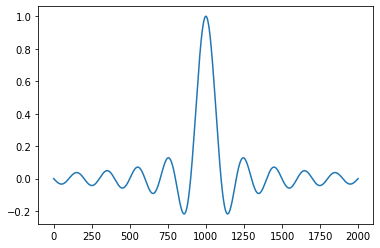

In [153]:
x = np.linspace(-10, 10, 2000)
s = np.sinc(x)**1

plt.plot(s)

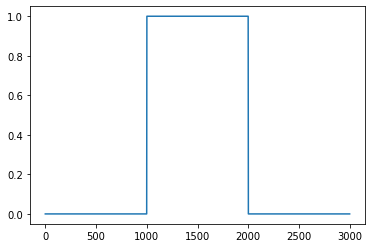

In [135]:
sig = np.repeat([0., 1., 0.], 1000)
plt.plot(sig)

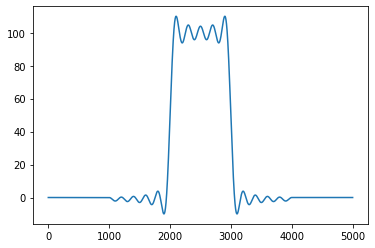

In [140]:
plt.plot((scipy.signal.convolve(sig, s)))

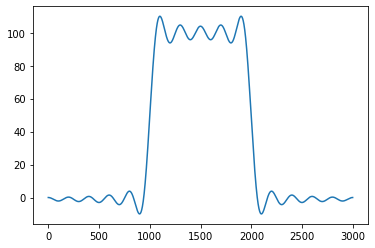

In [156]:
plt.plot((scipy.signal.convolve( np.repeat([1.], 1000), s)))

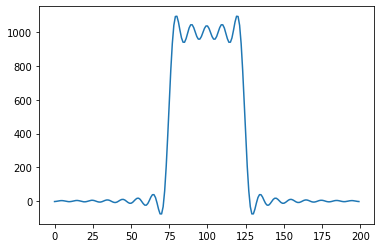

In [169]:
x = np.linspace(-100, 100, 1000)
s = 0

px_limit = 10.
px_range = np.linspace(-px_limit/2, px_limit/2, 10000)

for r in px_range:
    s += np.sinc(x+r)

# for i in range(10):
#     s += np.sinc(x+1*i)**1

plt.plot((s)[400:600])

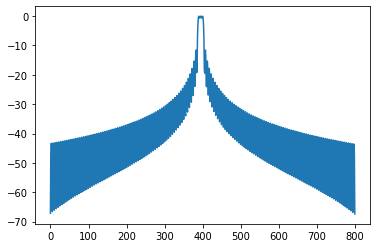

In [76]:
x = np.linspace(-100, 100, 1000)
s = np.sinc(x)**2 + np.sinc(x+1)**2 + np.sinc(x+2)**2

plt.plot(db(s)[100:-100])

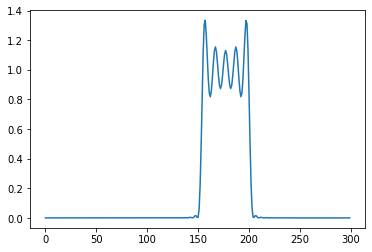

In [128]:
x = np.linspace(-100, 100, 1000)
s = 0
for i in range(10):
    s += np.sinc(x+1*i)**1

plt.plot((s)[300:600]**2)

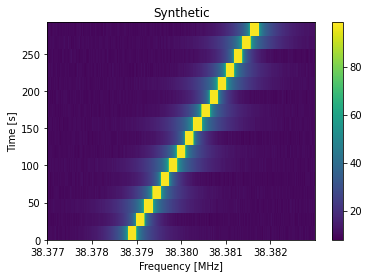

In [263]:
df = 2.7939677238464355
dt = 18.25361108
drift_rate = 5*2



frame = stg.Frame(fchans=2148*u.pixel,
                  tchans=16*u.pixel,
                  df=df*u.Hz,
                  dt=dt*u.s,
                  fch1=38.377*u.MHz,
                  ascending=True)

def my_chirp_profile(f, f_center):
    num_px = dt * drift_rate / df
    
    px_range = np.linspace(-num_px/2, num_px/2, 100)

    s = np.zeros(f.shape)
    for r in px_range:
        s += np.sinc((f - f_center)/df + r)
        
    return s**2

noise = frame.add_noise(x_mean=10, noise_type='chi2')
signal = frame.add_signal(stg.constant_path(f_start=chan_bw*13.1,
                                            drift_rate=drift_rate*u.Hz/u.s),
                          stg.constant_t_profile(level=frame.get_intensity(snr=1e10)),
                          my_chirp_profile,
                          stg.constant_bp_profile(level=1))

frame.bl_render()

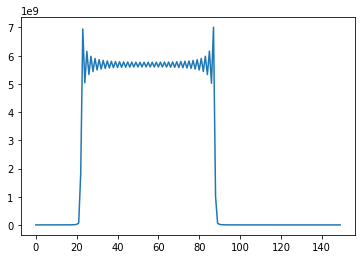

In [264]:
x = (frame.data[8, 1150:1300])
plt.plot((x))

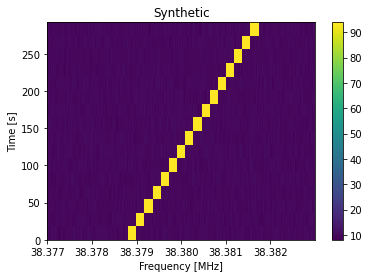

In [274]:
df = 2.7939677238464355
dt = 18.25361108
drift_rate = 5*2



frame = stg.Frame(fchans=2148*u.pixel,
                  tchans=16*u.pixel,
                  df=df*u.Hz,
                  dt=dt*u.s,
                  fch1=38.377*u.MHz,
                  ascending=True)


noise = frame.add_noise(x_mean=10, noise_type='chi2')
signal = frame.add_signal(stg.constant_path(f_start=chan_bw*13.1,
                                            drift_rate=drift_rate*u.Hz/u.s),
                          stg.constant_t_profile(level=frame.get_intensity(snr=1e10)),
                          stg.box_f_profile(width=frame.dt*drift_rate),
                          stg.constant_bp_profile(level=1))

frame.bl_render()

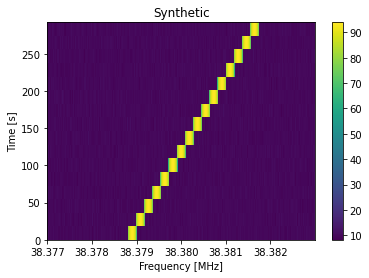

In [276]:
df = 2.7939677238464355
dt = 18.25361108
drift_rate = 5*2



frame = stg.Frame(fchans=2148*u.pixel,
                  tchans=16*u.pixel,
                  df=df*u.Hz,
                  dt=dt*u.s,
                  fch1=38.377*u.MHz,
                  ascending=True)


noise = frame.add_noise(x_mean=10, noise_type='chi2')
signal = frame.add_signal(stg.constant_path(f_start=chan_bw*13.1,
                                            drift_rate=drift_rate*u.Hz/u.s),
                          stg.constant_t_profile(level=frame.get_intensity(snr=1e10)),
                          stg.sinc2_f_profile(width=frame.dt*drift_rate/2),
                          stg.constant_bp_profile(level=1))

frame.bl_render()

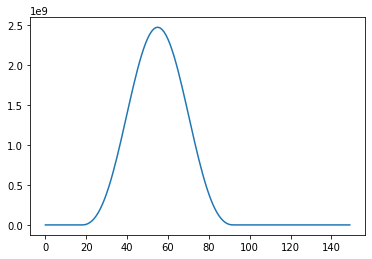

In [277]:
x = (frame.data[8, 1150:1300])
plt.plot((x))

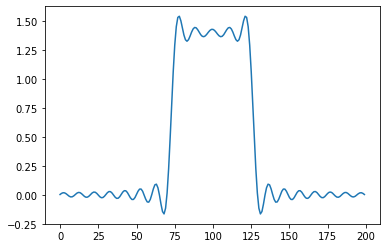

In [249]:
x = np.linspace(-100, 100, 1000)
s = 0

px_limit = 10.
px_range = np.linspace(-px_limit/2, px_limit/2, 15)

for r in px_range:
    s += np.sinc(x+r)

# for i in range(10):
#     s += np.sinc(x+1*i)**1

plt.plot((s)[400:600])

In [250]:

noise = frame.add_noise(x_mean=10, noise_type='chi2')
signal = frame.add_signal(stg.constant_path(f_start=frame.get_frequency(index=200),
                                            drift_rate=2*u.Hz/u.s),
                          stg.constant_t_profile(level=frame.get_intensity(snr=30)),
                          stg.box_f_profile(width=40*u.Hz),
                          stg.constant_bp_profile(level=1))

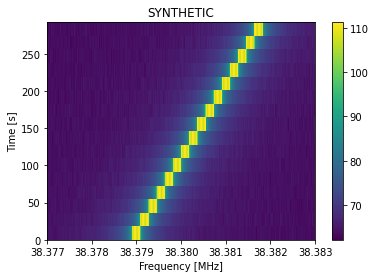

In [232]:
wf = bl.Waterfall('/datax/scratch/bbrzycki/data/raw_files/test_5min.rawspec.0000.fil',
                  f_start=38.377,
                  f_stop=38.383)
wf.plot_waterfall()

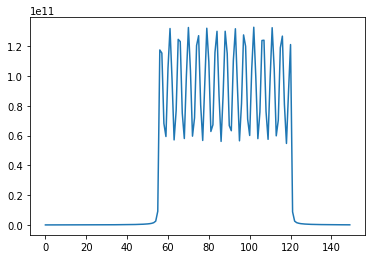

In [233]:
x = (wf.data[8, 0, 1150:1300])
plt.plot((x))

In [104]:
chan_bw/1e6*13.1

38.37890625

In [198]:
frame = stg.Frame(wf)
print(frame.shape, frame.dt, frame.df)
frame.dt * 5 / frame.df

(16, 2148) 18.253611007999982 2.7939677238464355


32.66610929719396

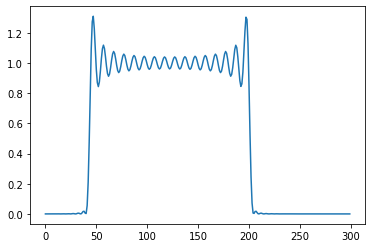

In [141]:
x = np.linspace(-100, 100, 1000)
s = 0
for i in range(int(frame.dt * 5 / frame.df)):
    s += np.sinc(x+1*i)**1

plt.plot((s)[300:600]**2)

In [106]:
frame.dt, frame.df

(18.253611007999982, 2.7939677238464355)

real v: 1.0220362347864569e-08 0.0019531240153603789
power before channelize: 3.8146934194819055e-06 2.697399521067118e-06
point 1: 1.0220362347864569e-08 0.0019531240153603789
point 2: -5.0964303599041615e-09 0.0018710105349234207
real part of channelized v: -6.442120157259006e-07 0.001320381919121309
power after channelize: 3.4938565773611474e-06 7.952664743941246e-05
power after fine channelize: 2.8005444127871524e-05 0.0014416446231326865
Shape after integration: (32, 32768)


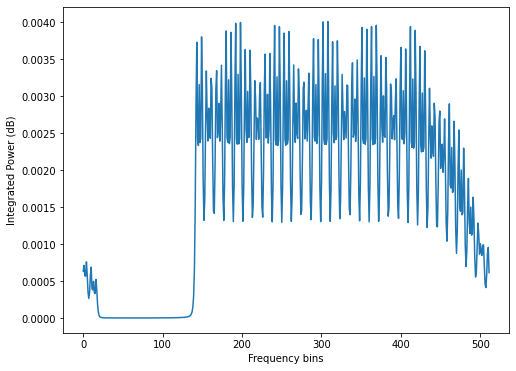

(0.0017329871737425519, 0.004006508255405467)

In [377]:
###############################
num_windows = 1024 * 2


sample_rate = 3e9
num_taps = 8
num_branches = 1024

chan_bw = sample_rate / num_branches

digitizer = stg.voltage.RealQuantizer(target_fwhm=32,
                                      num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

num_bits = 8
target_fwhm = 32*2**num_bits/2**8
requantizer = stg.voltage.ComplexQuantizer(target_fwhm=target_fwhm,
                                           num_bits=num_bits)


fftlength = 512

data = xp.zeros(num_branches * fftlength)
data[:num_taps*num_branches] = filterbank.window
h = xp.fft.fft(data)

half_coarse_chan = (xp.abs(h)**2)[:fftlength//2]+(xp.abs(h)**2)[fftlength//2:fftlength][::-1]

max_mean_ratio = xp.max(half_coarse_chan) / xp.mean(half_coarse_chan)

###############################

antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=0*u.GHz,
                              ascending=True,
                              num_pols=1,
                              seed=None)


num_pols = 1
int_factor = 1

antenna.x.add_constant_signal(f_start=chan_bw / fftlength * (int(fftlength * (2 + 5/20+0.025 - 0.5))), 
                              drift_rate=100000000*2, 
                              level=1 / (num_branches * fftlength / 4)**0.5 * 1/np.sinc(0.0),
                              mode='level')


# antenna.x.add_constant_signal(f_start=chan_bw / fftlength * int(fftlength * (2.5 - 0.5)), 
#                               drift_rate=0, 
#                               level=1 / (num_branches * fftlength / 4)**0.5,
#                               mode='level')

###############################


num_samples = num_taps * num_branches * (num_windows + 1)

v = antenna.x.get_samples(num_samples)

print('real v:', xp.mean(v), xp.std(v))
print('power before channelize:', xp.mean(xp.abs(v)**2), xp.std(xp.abs(v)**2))

# Digitizing
# v = digitizer.quantize(v)

# Channelizing
v = filterbank.channelize(v)

print('real part of channelized v:', xp.mean(v.real), xp.std(v.real))
print('power after channelize:', xp.mean(xp.abs(v)**2), xp.std(xp.abs(v)**2))

# Requantizing
# v = requantizer.quantize(v)


# Truncate coarse channels to the first 64.
pfb_voltages = v[:, 0:64]

X_samples = pfb_voltages.T
X_samples = X_samples[:, :(X_samples.shape[1] // fftlength) * fftlength]
X_samples = X_samples.reshape((X_samples.shape[0], X_samples.shape[1] // fftlength, fftlength))

XX = xp.fft.fft(X_samples, fftlength, axis=2) / fftlength**0.5
XX = xp.fft.fftshift(XX, axes=2)
XX_psd = xp.abs(XX)**2 
print('power after fine channelize:', xp.mean(XX_psd), xp.std(XX_psd))

XX_psd = xp.concatenate(XX_psd, axis=1)

# Integrate over time, trimming if necessary
XX_psd = XX_psd[:(XX_psd.shape[0] // int_factor) * int_factor]
XX_psd = XX_psd.reshape(XX_psd.shape[0] // int_factor, int_factor, XX_psd.shape[1])
XX_psd = XX_psd.sum(axis=1)

print('Shape after integration:', XX_psd.shape)

plt.figure(figsize=(8, 6))
coarse_chan = 2
A_n = np.sum(get_numpy(XX_psd), axis=0)[coarse_chan*fftlength:(coarse_chan+1)*fftlength] / XX_psd.shape[0] 
plt.plot((A_n))
# B = xp.concatenate([half_coarse_chan[::-1], half_coarse_chan])/xp.mean(half_coarse_chan) / (max_mean_ratio) * int_factor#* main_mean #* XX_psd.shape[0] 
# B = get_numpy(B)
# plt.plot((B))
# plt.plot((B*(1+get_numpy(num_SNR*SNR))))
plt.xlabel("Frequency bins")
plt.ylabel("Integrated Power (dB)")
plt.show()

np.mean(A_n), np.max(A_n)

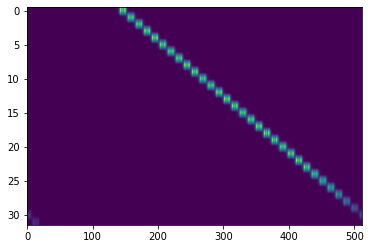

In [378]:
plt.imshow(get_numpy(XX_psd)[:,coarse_chan*fftlength:(coarse_chan+1)*fftlength], aspect='auto')

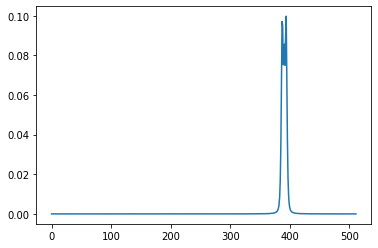

In [379]:
plt.plot(get_numpy(XX_psd)[20, coarse_chan*fftlength:(coarse_chan+1)*fftlength])

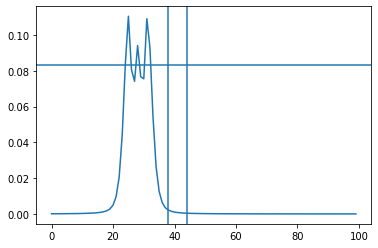

In [400]:
plt.plot(get_numpy(XX_psd)[19, coarse_chan*fftlength:(coarse_chan+1)*fftlength][350:450])
plt.axhline(1/12)
plt.axvline(38) 
plt.axvline(44)

In [278]:
chan_bw / fftlength

5722.0458984375

In [280]:
num_branches / sample_rate

3.413333333333333e-07

In [321]:
tchans = num_taps * num_windows / fftlength
tchans

32.0

In [322]:
num_samples = num_taps * num_branches * num_windows
obs_length = num_samples / sample_rate
num_samples, obs_length

(16777216, 0.005592405333333333)

In [323]:
obs_length / tchans

0.00017476266666666666

In [382]:
drift_rate = 100000000*2
df = chan_bw / fftlength
dt = obs_length / tchans
df, dt

(5722.0458984375, 0.00017476266666666666)

In [383]:
drift_rate * dt / df

6.108397932088889

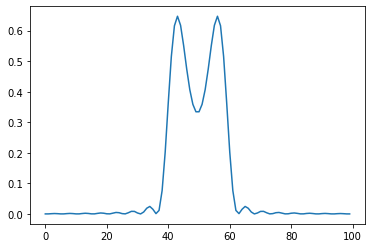

In [336]:
x = np.linspace(-10, 10, 100)
s = 0

px_limit = 3.
px_range = np.linspace(-px_limit/2, px_limit/2, 3)

for r in px_range:
    s += np.sinc(x+r)

# for i in range(10):
#     s += np.sinc(x+1*i)**1

plt.plot((s)**2)

In [402]:
chan_bw/1024

2861.02294921875

In [ ]:
tchans = num_samples / num_branches / fftlength
num_samples = obs_length / tbin * num_branches

tchans = obs_length / tbin / fftlength
dt = obs_length / tchans = tbin * fftlength



In [404]:
chan_bw / fftlength * int(fftlength*(2+0.3-0.5))/1e6

5.2700042724609375

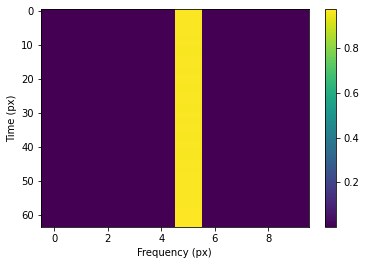

In [453]:
wf = bl.Waterfall('/datax/scratch/bbrzycki/data/raw_files/test_snr_actual.rawspec.0000.fil',
                  f_start=5.26,
                  f_stop=5.29)
frame = stg.Frame(wf)
frame.data /= 1024
frame.data /= (13.5891488)**2 * 2 * get_numpy(max_mean_ratio) 
frame.render()

In [454]:
np.max(frame.data)

0.9746672

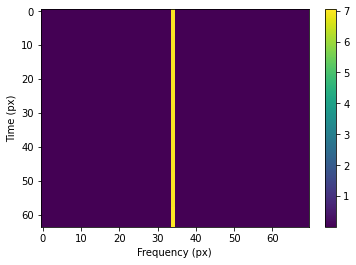

In [455]:
f = chan_bw / fftlength * int(fftlength*(2+0.6-0.5))/1e6
wf = bl.Waterfall('/datax/scratch/bbrzycki/data/raw_files/test_snr_actual.rawspec.0000.fil',
                  f_start=f-0.1,
                  f_stop=f+0.1)
frame = stg.Frame(wf)
frame.data /= 1024
frame.data /= (13.5891488)**2 * 2 * get_numpy(max_mean_ratio)
frame.render()

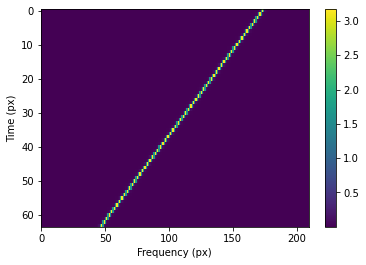

In [457]:
f = chan_bw / fftlength * int(fftlength*(4+0.2-0.5)) / 1e6
wf = bl.Waterfall('/datax/scratch/bbrzycki/data/raw_files/test_snr_actual.rawspec.0000.fil',
                  f_start=f-0.1,
                  f_stop=f+0.5)
frame = stg.Frame(wf)
frame.data /= 1024
frame.data /= (13.5891488)**2 * 2 * get_numpy(max_mean_ratio)
frame.render()

In [459]:
frame.df, frame.dt

(2861.02294921875, 0.002796202666666664)

In [428]:
chan_bw / 1024

2861.02294921875

In [ ]:

0.17895697066666666 3.413333333333333e-07 512.0
Creating block 0...

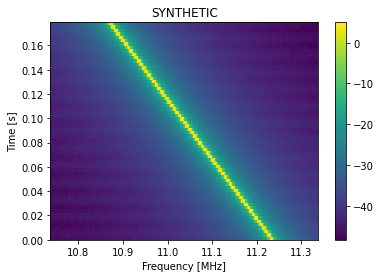

In [458]:
frame.bl_render()

In [460]:
frame.df/frame.dt

1023181.5394945453

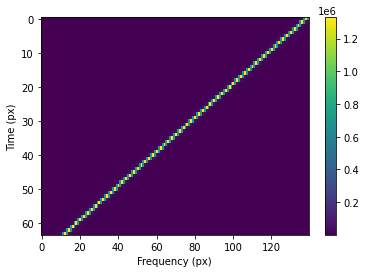

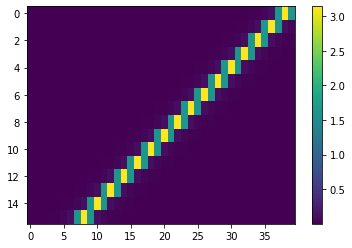

In [505]:
f = (chan_bw / fftlength * int(fftlength*(4+0.2-0.5))) / 1e6
wf = bl.Waterfall('/datax/scratch/bbrzycki/data/raw_files/test_snr_actual.rawspec.0000.fil',
                  f_start=f-0.,
                  f_stop=f+0.4)
frame = stg.Frame(wf)
frame.render()
plt.show()
frame.data /= 1024
frame.data /= (13.5891488)**2 * 2 * get_numpy(max_mean_ratio)
plt.imshow(frame.data[0:16, 100:], aspect='auto', interpolation='none')
plt.colorbar()

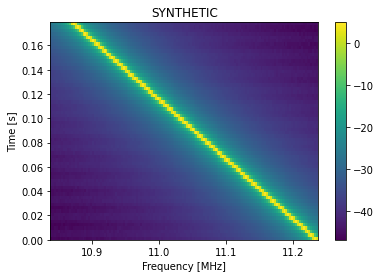

In [502]:
frame.bl_render()

In [492]:
f, (chan_bw / fftlength * int(fftlength*(4+0.2-0.5)) + 10 * frame.df)/1e6

(10.837554931640625, 10.866165161132812)

In [489]:
chan_bw / fftlength * int(fftlength*(4+0.2-0.5)) / 1e6

10.837554931640625

In [498]:
frame.get_frequency(100)/1e6

11.524200439453125

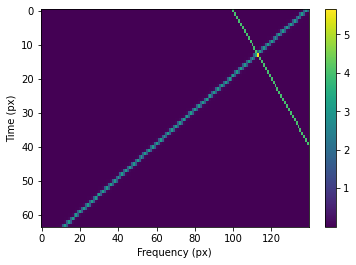

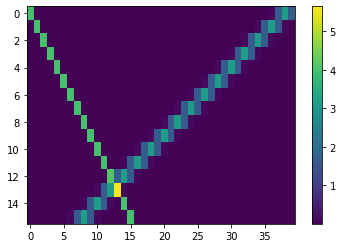

In [500]:
f1 = chan_bw / fftlength * int(fftlength*(4+0.2-0.5)) + 10 * frame.df

frame.add_constant_signal(f_start=frame.get_frequency(100),
                          drift_rate = frame.df/frame.dt,
                          level = 4,
                          width = 3,
                         f_profile_type='box')
frame.render()
plt.show()
plt.imshow(frame.data[0:16, 100:], aspect='auto', interpolation='none')
plt.colorbar()

In [516]:
wf.header

{'machine_id': 20,
 'telescope_id': 6,
 'src_raj': <Angle 4.69605333 hourangle>,
 'src_dej': <Angle 25.6911 deg>,
 'az_start': 0.0,
 'za_start': 0.0,
 'data_type': 1,
 'fch1': 188.96484375,
 'foff': -0.00286102294921875,
 'nchans': 65536,
 'nbeams': 1,
 'ibeam': -1,
 'nbits': 32,
 'tstart': 59114.183657407404,
 'tsamp': 0.002796202666666664,
 'nifs': 1,
 'source_name': 'SYNTHETIC',
 'rawdatafile': 'test_snr_actual.0000.raw'}

In [507]:
frame.header

{'machine_id': 20,
 'telescope_id': 6,
 'src_raj': <Angle 4.69605333 hourangle>,
 'src_dej': <Angle 25.6911 deg>,
 'az_start': 0.0,
 'za_start': 0.0,
 'data_type': 1,
 'fch1': -1.46484375,
 'foff': 0.00286102294921875,
 'nchans': 65536,
 'nbeams': 1,
 'ibeam': -1,
 'nbits': 32,
 'tstart': 59114.183657407404,
 'tsamp': 0.002796202666666664,
 'nifs': 1,
 'source_name': 'SYNTHETIC',
 'rawdatafile': 'test_snr_actual.0000.raw'}

In [508]:
frame.df

2861.02294921875

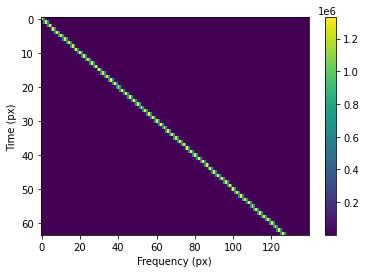

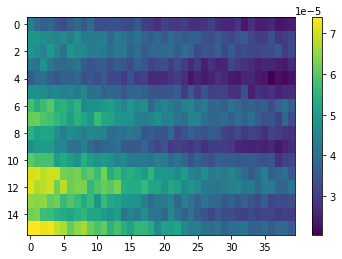

In [549]:
f = (chan_bw / fftlength * int(fftlength*(4+0.2-0.5))) / 1e6
wf = bl.Waterfall('/datax/scratch/bbrzycki/data/raw_files/test_snr_actual.rawspec.0000.fil',
                  f_start=f-0.,
                  f_stop=f+0.4)
frame = stg.Frame(wf)
frame.render()
plt.show()
frame.data /= 1024
frame.data /= (13.5891488)**2 * 2 * get_numpy(max_mean_ratio)
plt.imshow(frame.data[0:16, 100:], aspect='auto', interpolation='none')
plt.colorbar()

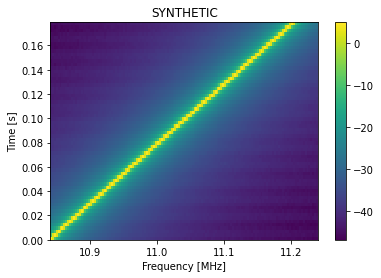

In [517]:
frame.bl_render()

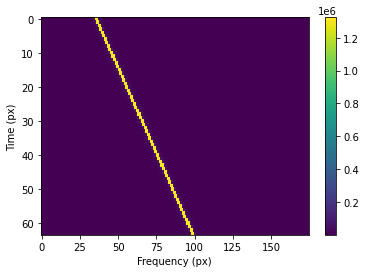

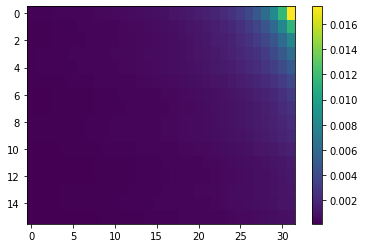

In [685]:
f = (chan_bw / fftlength * int(fftlength*(4+0.2-0.5))) / 1e6
wf = bl.Waterfall('/datax/scratch/bbrzycki/data/raw_files/test_snr_actual_asc.rawspec.0000.fil',
                  f_start=f-0.1,
                  f_stop=f+0.4)
frame = stg.Frame(wf)
frame.render()
plt.show()
frame.data /= 1024
frame.data /= (13.5891488)**2 * 2 * get_numpy(max_mean_ratio)
plt.imshow(frame.data[0:16, :32], aspect='auto', interpolation='none')
plt.colorbar()

In [710]:
idx_b = np.expand_dims(np.arange(frame.data.shape[0]), 1) + np.expand_dims(np.arange(100), 1).T
idx_b.shape

(64, 100)

In [707]:
idx_a = np.expand_dims(np.arange(frame.data.shape[0]), 1).repeat(100, axis=1)
idx_a.shape

(64, 100)

In [712]:
frame.data[idx_a, idx_b].shape

(64, 100)

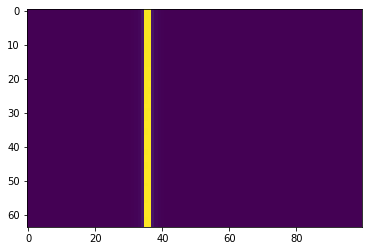

In [713]:
plt.imshow(frame.data[idx_a, idx_b], aspect='auto', interpolation='none')


In [697]:
idx = np.expand_dims(np.arange(frame.data.shape[0]), 0) + np.expand_dims(np.arange(100), 0).T
frame.data[:, idx]

array([[[2.79554690e-04, 2.95916630e-04, 3.22093372e-04, ...,
         5.36830688e-04, 5.00829541e-04, 4.68732702e-04],
        [2.95916630e-04, 3.22093372e-04, 3.46791086e-04, ...,
         5.00829541e-04, 4.68732702e-04, 4.22558805e-04],
        [3.22093372e-04, 3.46791086e-04, 3.65850690e-04, ...,
         4.68732702e-04, 4.22558805e-04, 3.95329349e-04],
        ...,
        [9.99286494e-05, 9.16152276e-05, 8.95406702e-05, ...,
         2.95572536e-05, 2.85721235e-05, 2.93368394e-05],
        [9.16152276e-05, 8.95406702e-05, 8.58008425e-05, ...,
         2.85721235e-05, 2.93368394e-05, 3.08349881e-05],
        [8.95406702e-05, 8.58008425e-05, 8.61980152e-05, ...,
         2.93368394e-05, 3.08349881e-05, 2.86238246e-05]],

       [[2.37582382e-04, 2.42588823e-04, 2.59523746e-04, ...,
         6.57772238e-04, 6.05613925e-04, 5.68153220e-04],
        [2.42588823e-04, 2.59523746e-04, 2.78152555e-04, ...,
         6.05613925e-04, 5.68153220e-04, 5.28748555e-04],
        [2.59523746e-04, 

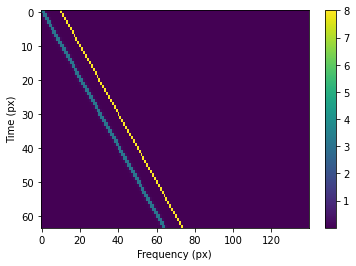

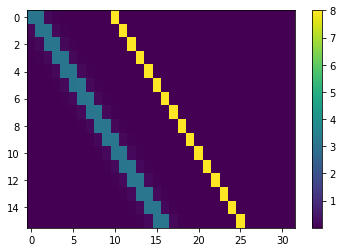

In [682]:
f1 = f*1e6 + 10 * frame.df

frame.add_constant_signal(f_start=f1,
                          drift_rate = frame.df/frame.dt*1,
                          level = 4,
                          width = frame.df,
                         f_profile_type='box')
frame.render()
plt.show()
plt.imshow(frame.data[0:16, :32], aspect='auto', interpolation='none')
plt.colorbar()

In [615]:
frame.df, frame.dt

(2861.02294921875, 0.002796202666666664)

In [604]:
frame.dt*64

0.1789569706666665

In [603]:
frame.df / frame.dt

1023181.5394945453

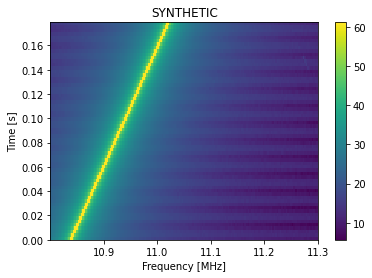

In [679]:
wf = bl.Waterfall('/datax/scratch/bbrzycki/data/raw_files/test_snr_actual_asc.rawspec.0000.fil',
                  f_start=10.8,
                  f_stop=11.3)
wf.plot_waterfall()

In [557]:
wf = bl.Waterfall('/datax/scratch/bbrzycki/data/raw_files/test_snr_actual_asc.rawspec.0000.fil',
                  f_start=f-0.,
                  f_stop=f+0.4)
wf.header

{'machine_id': 20,
 'telescope_id': 6,
 'src_raj': <Angle 4.69605333 hourangle>,
 'src_dej': <Angle 25.6911 deg>,
 'az_start': 0.0,
 'za_start': 0.0,
 'data_type': 1,
 'fch1': -1.46484375,
 'foff': 0.00286102294921875,
 'nchans': 65536,
 'nbeams': 1,
 'ibeam': -1,
 'nbits': 32,
 'tstart': 59114.183657407404,
 'tsamp': 0.002796202666666664,
 'nifs': 1,
 'source_name': 'SYNTHETIC',
 'rawdatafile': 'test_snr_actual_asc.0000.raw'}

In [560]:
stg.Frame(wf).fch1

11238098.14453125

In [561]:
wf.container.f_start, wf.container.f_stop

(10.837554931640625, 11.23809814453125)

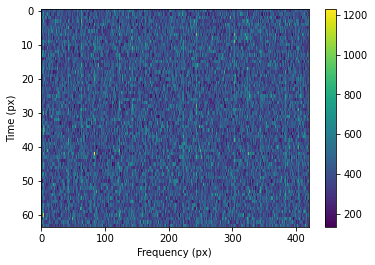

In [94]:
f = chan_bw / fftlength * int(fftlength*(2+0.6-0.5))/1e6
wf = bl.Waterfall('/datax/scratch/bbrzycki/data/raw_files/test_snr_actual_asc.rawspec.0000.fil',
                  f_start=f-0.6,
                  f_stop=f+0.6)
frame = stg.Frame(wf)
frame.render()

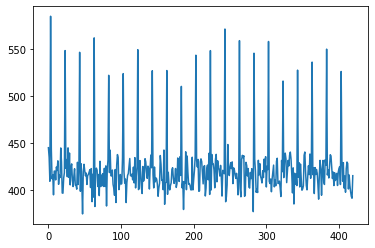

In [95]:
spectrum = np.mean(frame.data, axis=0)# / 8 / 1024
plt.plot(spectrum)

In [44]:
np.mean(spectrum), np.std(spectrum)

(413.95044, 12.595417)

In [86]:
mean = (13.5891488)**2 * 2 * get_numpy(max_mean_ratio) * 2 * 8 * 1024 / 127**2
mean

416.507272559642

In [88]:
chi_df = 2 * 2 * 8
mean * np.sqrt(2 / chi_df) / np.sqrt(64)

13.015852267488812

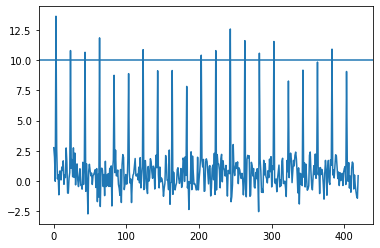

In [96]:
plt.plot((spectrum-410.0247680123575)/12.813274000386173)
plt.axhline(10)

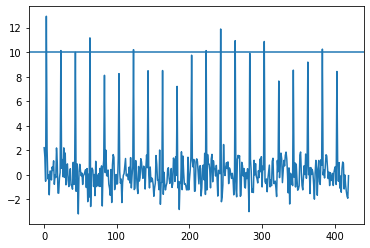

In [97]:
plt.plot((spectrum-416.507272559642)/13.015852267488812)
plt.axhline(10)

In [85]:
spectrum[:200].mean(), spectrum[:200].std()

(413.9202, 12.748312)

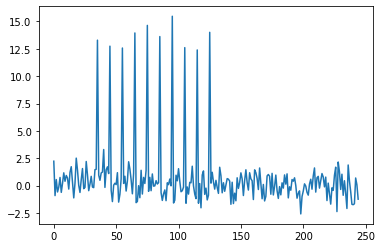

In [21]:
noise = spectrum[150:]
plt.plot((spectrum-np.mean(noise))/np.std(noise))

In [761]:
np.argsort(spectrum)[-1]

35

In [762]:
noise = spectrum[45:]
np.mean(noise), np.std(noise)

(208.17339, 6.877691)

In [763]:
np.max(spectrum)

271.6635

In [764]:
(np.max(spectrum)-np.mean(noise))/np.std(noise)

9.231315

real v: 0.0002337080652986495 2.000145769371448
power before channelize: 4.000583153353962 5.658632981027105
real part of channelized v: 0.002087683183576794 9.12802368772639
power after channelize: 166.0537851817698 166.4021584178738
power after fine channelize: 369.61547088623047 381.2415206568317
Shape after integration: (64, 32768)


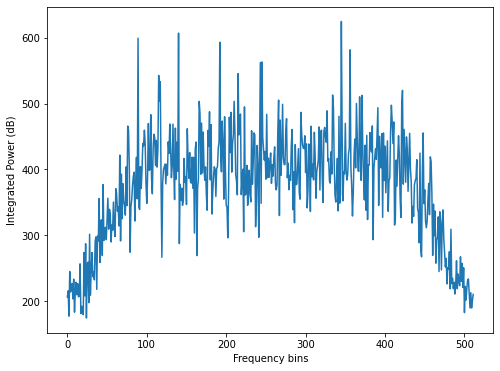

(373.0198974609375, 624.9404465066704)

In [50]:
###############################

sample_rate = 3e9
num_taps = 8
num_branches = 1024

chan_bw = sample_rate / num_branches

digitizer = stg.voltage.RealQuantizer(target_fwhm=32,
                                      num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

num_bits = 8
target_fwhm = 32*2**num_bits/2**8
requantizer = stg.voltage.ComplexQuantizer(target_fwhm=target_fwhm,
                                           num_bits=num_bits)


fftlength = 512

data = xp.zeros(num_branches * fftlength)
data[:num_taps*num_branches] = filterbank.window
h = xp.fft.fft(data)

half_coarse_chan = (xp.abs(h)**2)[:fftlength//2]+(xp.abs(h)**2)[fftlength//2:fftlength][::-1]

max_mean_ratio = xp.max(half_coarse_chan) / xp.mean(half_coarse_chan)

###############################

antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=0*u.GHz,
                              ascending=True,
                              num_pols=1,
                              seed=None)

antenna.x.add_noise(v_mean=0, 
                    v_std=2)

for i in range(20):
    antenna.x.add_constant_signal(f_start=chan_bw / fftlength * int(fftlength * (2 + i/20+0.025 - 0.5)), 
                              drift_rate=0, 
                              level=1 / (num_branches * fftlength / 4)**0.5 * 1**0.5,
                              mode='level')


# antenna.x.add_constant_signal(f_start=chan_bw / fftlength * int(fftlength * (2.5 - 0.5)), 
#                               drift_rate=0, 
#                               level=1 / (num_branches * fftlength / 4)**0.5,
#                               mode='level')

###############################

num_windows = 1024 * 4
num_samples = num_taps * num_branches * (num_windows + 1)

v = antenna.x.get_samples(num_samples)

print('real v:', xp.mean(v), xp.std(v))
print('power before channelize:', xp.mean(xp.abs(v)**2), xp.std(xp.abs(v)**2))

# Digitizing
v = digitizer.quantize(v)

# Channelizing
v = filterbank.channelize(v)

print('real part of channelized v:', xp.mean(v.real), xp.std(v.real))
print('power after channelize:', xp.mean(xp.abs(v)**2), xp.std(xp.abs(v)**2))

# Requantizing
v = requantizer.quantize(v)

int_factor=1

# Truncate coarse channels to the first 64.
pfb_voltages = v[:, 0:64]

X_samples = pfb_voltages.T
X_samples = X_samples[:, :(X_samples.shape[1] // fftlength) * fftlength]
X_samples = X_samples.reshape((X_samples.shape[0], X_samples.shape[1] // fftlength, fftlength))

XX = xp.fft.fft(X_samples, fftlength, axis=2) / fftlength**0.5
XX = xp.fft.fftshift(XX, axes=2)
XX_psd = xp.abs(XX)**2 
print('power after fine channelize:', xp.mean(XX_psd), xp.std(XX_psd))

XX_psd = xp.concatenate(XX_psd, axis=1)

# Integrate over time, trimming if necessary
XX_psd = XX_psd[:(XX_psd.shape[0] // int_factor) * int_factor]
XX_psd = XX_psd.reshape(XX_psd.shape[0] // int_factor, int_factor, XX_psd.shape[1])
XX_psd = XX_psd.sum(axis=1)

print('Shape after integration:', XX_psd.shape)

plt.figure(figsize=(8, 6))
coarse_chan = 2
A_n = np.sum(get_numpy(XX_psd), axis=0)[coarse_chan*fftlength:(coarse_chan+1)*fftlength] / XX_psd.shape[0] 
plt.plot((A_n))
B = xp.concatenate([half_coarse_chan[::-1], half_coarse_chan])/xp.mean(half_coarse_chan) / (max_mean_ratio) #* XX_psd.shape[0] 
B = get_numpy(B)
# plt.plot((B))
# plt.plot((11*B))
plt.xlabel("Frequency bins")
plt.ylabel("Integrated Power (dB)")
plt.show()

np.mean(A_n), np.max(A_n)

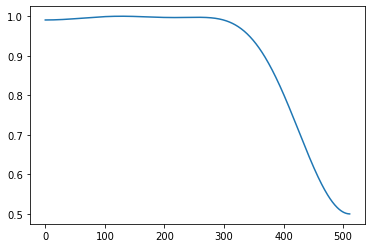

In [6]:
fftlength = 1024

data = np.zeros(num_branches * fftlength)
data[:num_taps*num_branches] = xp.asnumpy(filterbank.window)
h = np.fft.fft(data)
half_coarse_chan = (np.abs(h)**2)[:fftlength//2]+(np.abs(h)**2)[fftlength//2:fftlength][::-1]
max_mean_ratio = np.max(half_coarse_chan) / np.mean(half_coarse_chan)

plt.plot(half_coarse_chan/np.max(half_coarse_chan))

1.1113791496088377

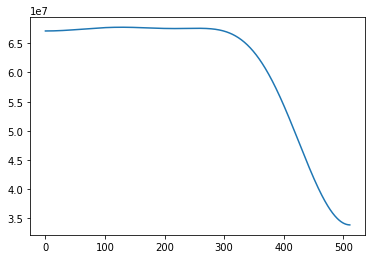

In [47]:
num_taps = 8
num_branches = 1024

length = 128 * num_taps

chan_bw = sample_rate / num_branches

digitizer = stg.voltage.RealQuantizer(target_fwhm=32,
                                      num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

num_bits = 8
target_fwhm = 32*2**num_bits/2**8
requantizer = stg.voltage.ComplexQuantizer(target_fwhm=target_fwhm,
                                           num_bits=num_bits)

data = np.zeros(num_branches * length)
data[:num_taps*num_branches] = xp.asnumpy(filterbank.window)
h = np.fft.fft(data)
half_coarse_chan = (np.abs(h)**2)[:length//2]+(np.abs(h)**2)[length//2:length][::-1]
plt.plot(half_coarse_chan)
np.max(half_coarse_chan) / np.mean(half_coarse_chan)

In [43]:
length

2048

1.1113791496088377

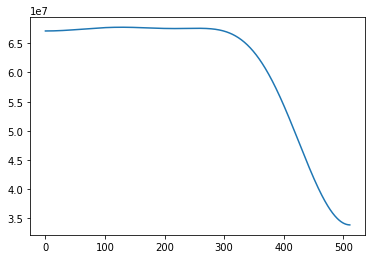

In [9]:
num_taps = 8
num_branches = 1024

length = 128 * num_taps

chan_bw = sample_rate / num_branches

digitizer = stg.voltage.RealQuantizer(target_fwhm=32,
                                      num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

num_bits = 8
target_fwhm = 32*2**num_bits/2**8
requantizer = stg.voltage.ComplexQuantizer(target_fwhm=target_fwhm,
                                           num_bits=num_bits)

data = np.zeros(num_branches * length)
data[:num_taps*num_branches] = xp.asnumpy(filterbank.window)
h = np.fft.fft(data)
half_coarse_chan = (np.abs(h)**2)[:length//2]+(np.abs(h)**2)[length//2:length][::-1]
plt.plot(half_coarse_chan)
np.max(half_coarse_chan) / np.mean(half_coarse_chan)

1.1113791496088377

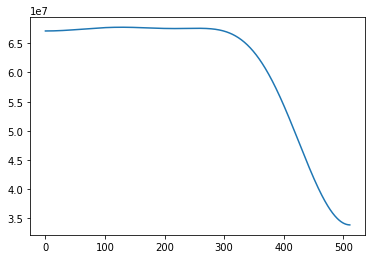

In [21]:
num_taps = 8
num_branches = 1024

length = 128 * num_taps

chan_bw = sample_rate / num_branches

digitizer = stg.voltage.RealQuantizer(target_fwhm=32,
                                      num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

num_bits = 8
target_fwhm = 32*2**num_bits/2**8
requantizer = stg.voltage.ComplexQuantizer(target_fwhm=target_fwhm,
                                           num_bits=num_bits)

data = np.zeros(num_branches * length)
data[:num_taps*num_branches] = xp.asnumpy(filterbank.window)
h = np.fft.fft(data)
half_coarse_chan = (np.abs(h)**2)[:length//2]+(np.abs(h)**2)[length//2:length][::-1]
plt.plot(half_coarse_chan)
np.max(half_coarse_chan) / np.mean(half_coarse_chan)

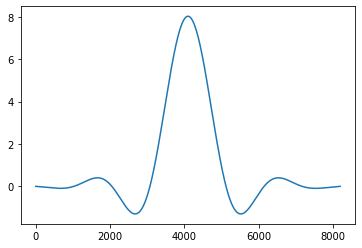

In [22]:
plt.plot(xp.asnumpy(filterbank.window))

In [25]:
3e9//8

375000000.0